<a href="https://colab.research.google.com/github/DovTech/unet_roofs_experiments/blob/main/unet_for_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Libs

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import gdown

In [3]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

###Files load

In [4]:
gdown.download("https://drive.google.com/file/d/1WHIGevf1Kz4yhKAyGKWLRcwnrliVc0gq/view?usp=drive_link", quiet=False, fuzzy=True) #train_small (img + msk)
gdown.download("https://drive.google.com/file/d/1MpYdtlbfdCoKW1K1qTcqA_en6RnBtb6g/view?usp=drive_link", quiet=False, fuzzy=True) #val_small (img + msk)
#gdown.download("https://drive.google.com/file/d/1qu98Ty75AdL-zC0l-4MFQPidSTCROEoL/view?usp=drive_link", quiet=False, fuzzy=True) #test_images (img)
gdown.download("https://drive.google.com/file/d/1OVJLngs_my3BJNks95-VifrHv-xdIxPW/view?usp=sharing", quiet=False, fuzzy=True) #test_img_msk (img + msk) [created by train dataset]
# gdown.download("https://drive.google.com/file/d/1uOk0jFM7rRdjX9aeUUQaP2qfXx0yoZ0m/view?usp=sharing", fuzzy=True) #best_model.pth

!unzip /content/train_small.zip
!unzip /content/val_small.zip
#!tar -xvf /content/test_images.tar.gz
!unzip /content/test_img_msk.zip

Downloading...
From: https://drive.google.com/uc?id=1WHIGevf1Kz4yhKAyGKWLRcwnrliVc0gq
To: /content/train_small.zip
100%|██████████| 421M/421M [00:03<00:00, 113MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1MpYdtlbfdCoKW1K1qTcqA_en6RnBtb6g
To: /content/val_small.zip
100%|██████████| 91.8M/91.8M [00:00<00:00, 173MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OVJLngs_my3BJNks95-VifrHv-xdIxPW
To: /content/test_img_msk.zip
100%|██████████| 3.84M/3.84M [00:00<00:00, 88.0MB/s]


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: content/val_small/masks/000000015133_mask.jpg  
  inflating: content/val_small/masks/000000036218_mask.jpg  
  inflating: content/val_small/masks/000000048332_mask.jpg  
  inflating: content/val_small/masks/000000037706_mask.jpg  
  inflating: content/val_small/masks/000000006237_mask.jpg  
  inflating: content/val_small/masks/000000050357_mask.jpg  
  inflating: content/val_small/masks/000000031921_mask.jpg  
  inflating: content/val_small/masks/000000034652_mask.jpg  
  inflating: content/val_small/masks/000000035483_mask.jpg  
  inflating: content/val_small/masks/000000051993_mask.jpg  
  inflating: content/val_small/masks/000000000108_mask.jpg  
  inflating: content/val_small/masks/000000046902_mask.jpg  
  inflating: content/val_small/masks/000000029294_mask.jpg  
  inflating: content/val_small/masks/000000052964_mask.jpg  
  inflating: content/val_small/masks/000000036788_mask.jpg  
  inflating: cont

In [5]:
# gdown.download("https://drive.google.com/file/d/1E8Tu1sHjmIoMZvpulgTZV5tGEUqwcmvf/view?usp=sharing", fuzzy=True)
# !unzip archive.zip

### Pathes

In [6]:
DATA_DIR = '/content/'

x_train_dir = os.path.join(DATA_DIR, 'train_small/images/')
y_train_dir = os.path.join(DATA_DIR, 'train_small/masks/')

# old_x_train_dir = os.path.join(DATA_DIR, 'png/train/')
# old_y_train_dir = os.path.join(DATA_DIR, 'png/train_labels/')

x_valid_dir = os.path.join(DATA_DIR, 'val_small/images/')
y_valid_dir = os.path.join(DATA_DIR, 'val_small/masks/')

# old_x_valid_dir = os.path.join(DATA_DIR, 'png/val/')
# old_y_valid_dir = os.path.join(DATA_DIR, 'png/val_labels/')

x_test_dir = os.path.join(DATA_DIR, 'test_images/')
y_test_dir = os.path.join(DATA_DIR, 'test_masks')

# old_x_test_dir = os.path.join(DATA_DIR, 'png/test/')
# old_y_test_dir = os.path.join(DATA_DIR, 'png/test_labels/')

In [7]:
for img, msk in zip(os.listdir(x_valid_dir)[100:], os.listdir(y_valid_dir)[100:]):
    os.remove(os.path.join(x_valid_dir, img))
    os.remove(os.path.join(y_valid_dir, msk))

### Shortlist specific classes to segment

In [8]:
# Useful to shortlist specific classes in datasets with large number of classes
class_dict = pd.DataFrame(data={
    "name": ["background", "building"],
    "r": [0, 0],
    #"r": [0, 255],
    "g": [0, 255],
    "b": [0, 0]
    #"b": [0, 255]
})
class_names = class_dict["name"]
select_class_rgb_values = class_dict[['r','g','b']].values.tolist()
select_classes = class_names.to_list()

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', select_class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  0    background
1      building
Name: name, dtype: object
Class RGB values:  [[0, 0, 0], [0, 255, 0]]


### Helper functions for viz. & one-hot encoding/decoding

In [9]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

###Create datasets

In [10]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        mask[mask < 250] = 0
        mask[mask >= 250] = 255

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

### Visualize Sample Image and Mask

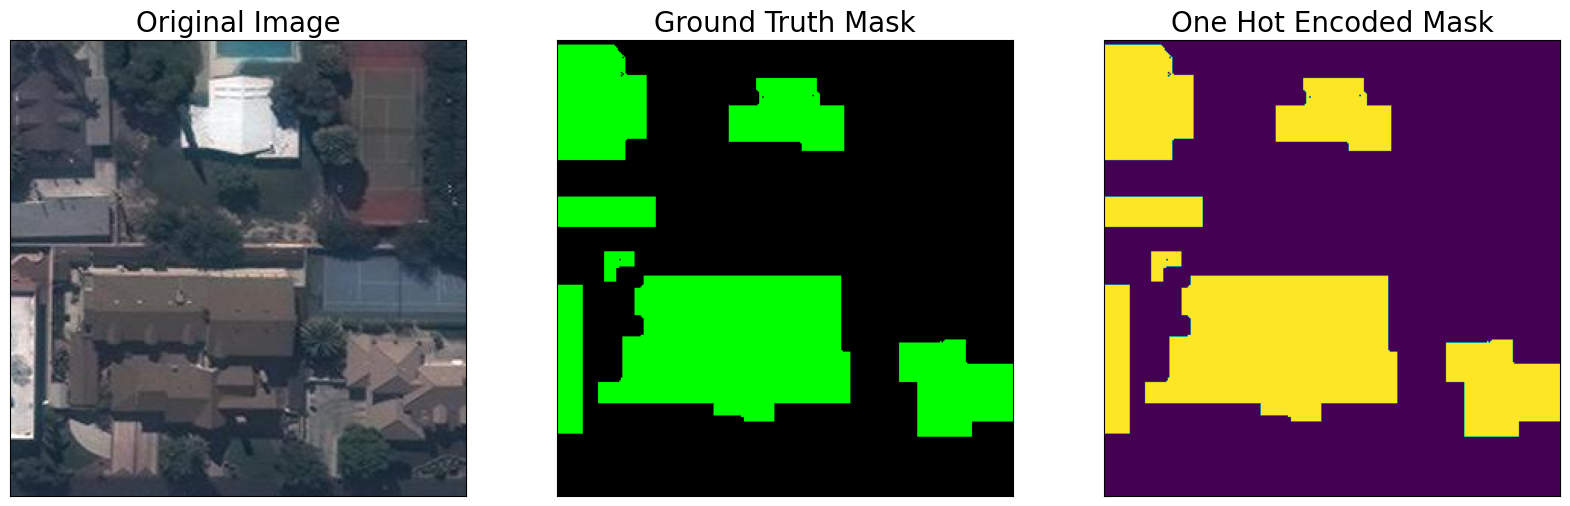

In [11]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [12]:
# old_class_rgb_values = [[0, 0, 0], [255, 255, 255]]
# old_dataset = BuildingsDataset(old_x_train_dir, old_y_train_dir, class_rgb_values=old_class_rgb_values)

# random_idx = random.randint(0, len(old_dataset)-1)
# image, mask = old_dataset[random_idx]

# visualize(
#     original_image = image,
#     ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), old_class_rgb_values),
#     one_hot_encoded_mask = reverse_one_hot(mask)
# )

### Defining Augmentations

In [13]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        # album.OneOf(
        #     [
        #         album.HorizontalFlip(p=1),
        #         album.VerticalFlip(p=1),
        #         album.RandomRotate90(p=1),
        #     ],
        #     p=0.75,
        # ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.CenterCrop(256, 256)
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

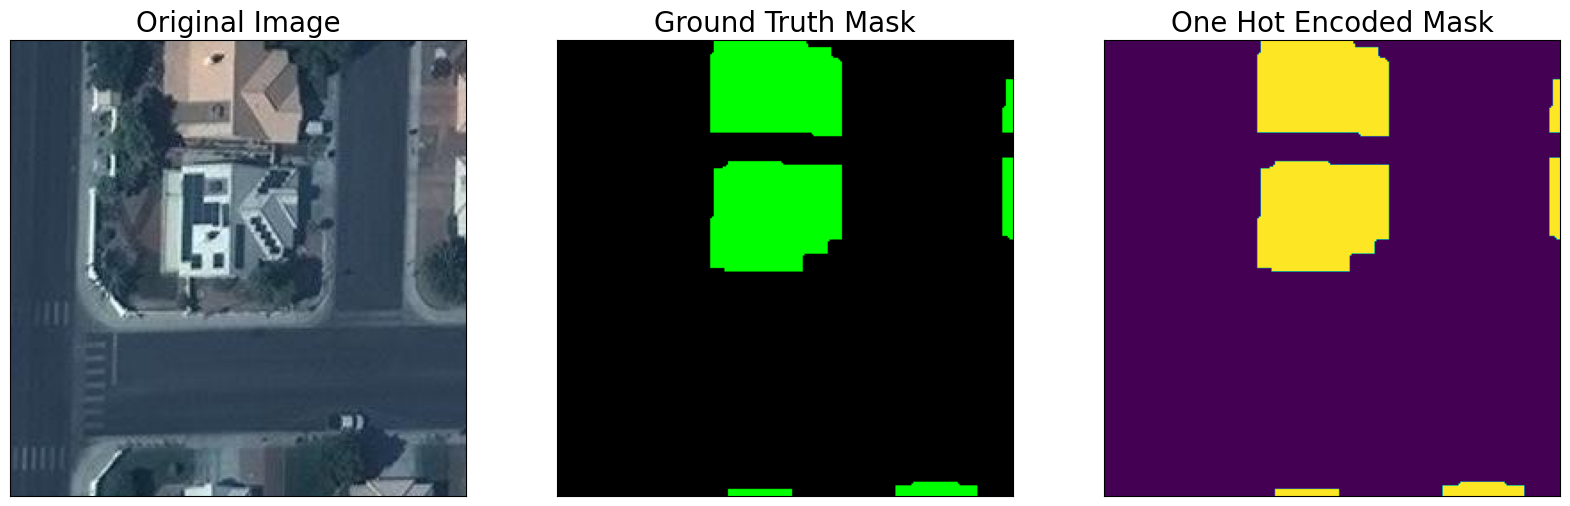

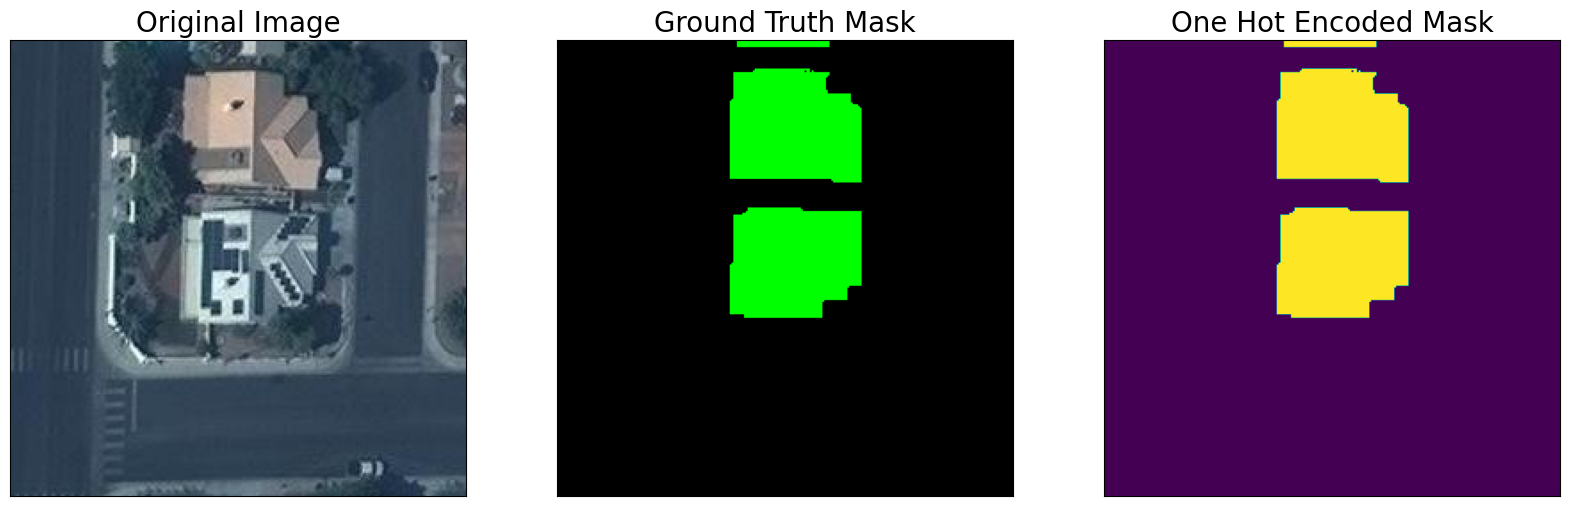

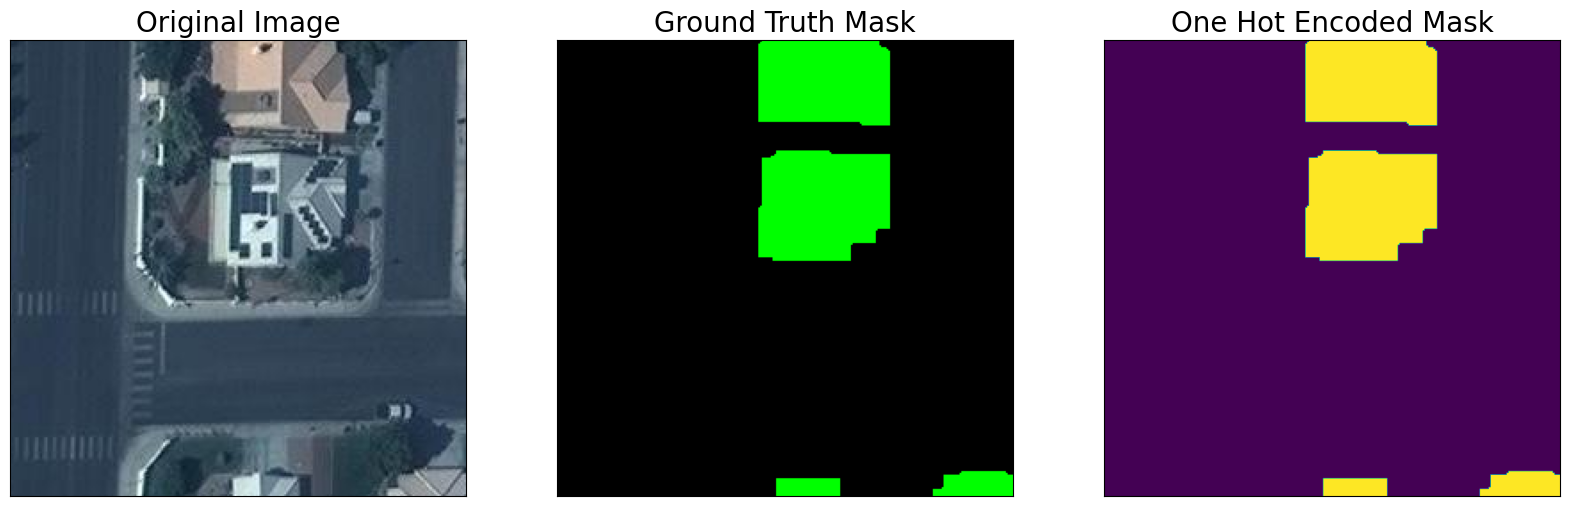

In [14]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

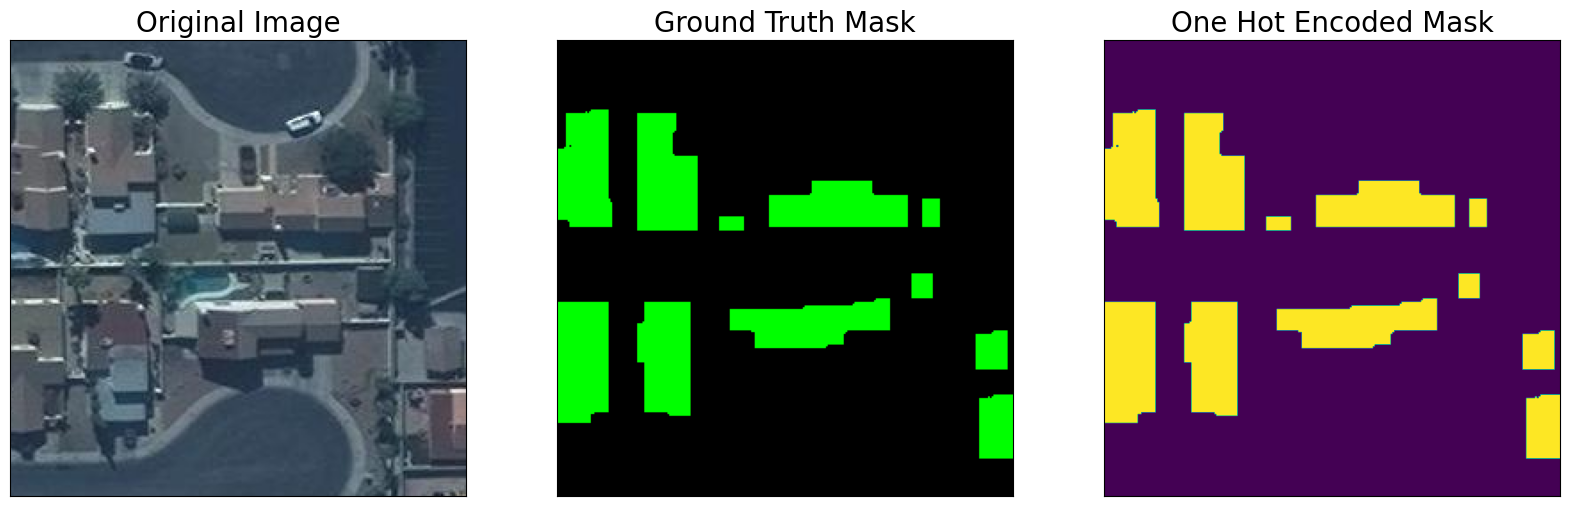

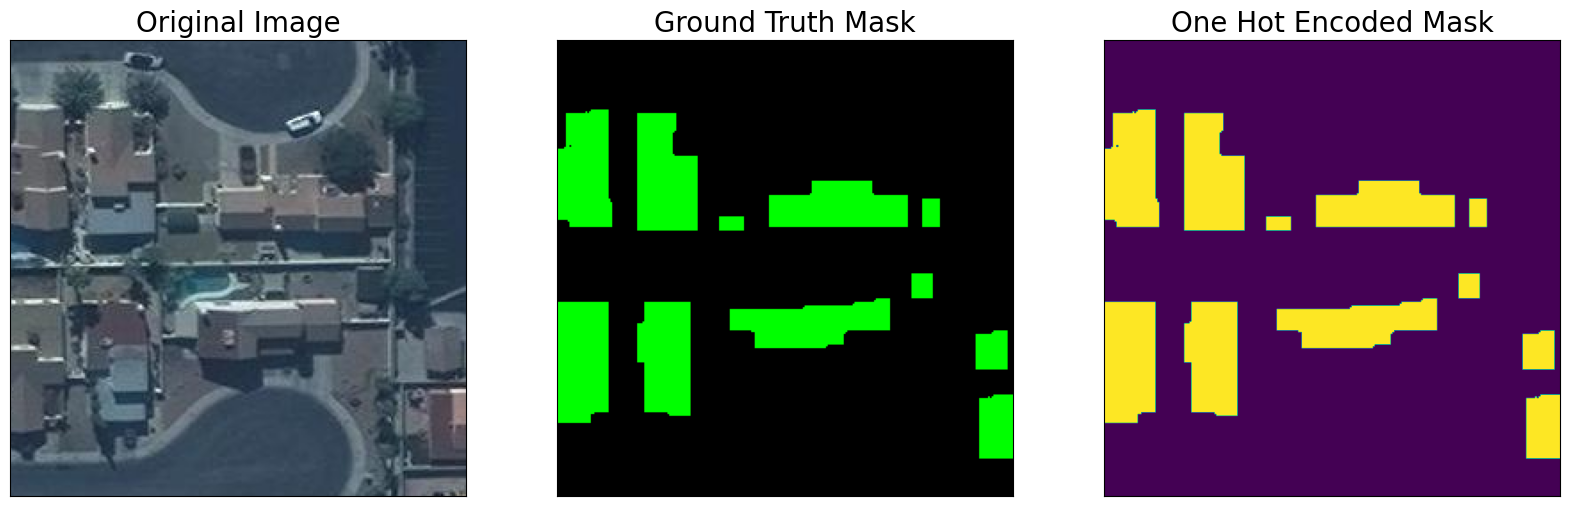

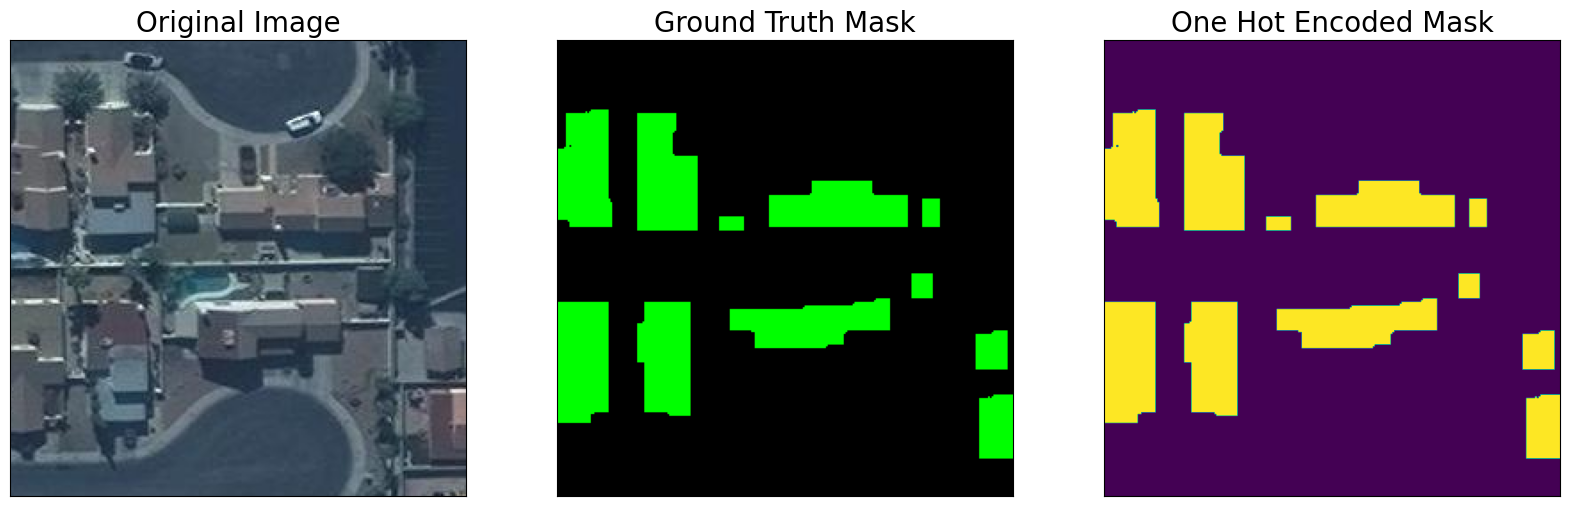

In [15]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [16]:
# old_augmented_dataset = BuildingsDataset(
#     old_x_train_dir, old_y_train_dir,
#     #augmentation=get_training_augmentation(),
#     class_rgb_values=old_class_rgb_values,
# )

# random_idx = random.randint(0, len(old_augmented_dataset)-1)

# # Different augmentations on a random image/mask pair (256*256 crop)
# for i in range(3):
#     image, mask = old_augmented_dataset[random_idx]
#     visualize(
#         original_image = image,
#         ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), old_class_rgb_values),
#         one_hot_encoded_mask = reverse_one_hot(mask)
#     )

## Training UNet

### Model Definition

####Model

In [17]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x


# Get UNet model
model = UNet()

#### Get Train / Val DataLoaders

In [18]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [19]:
# old_train_dataset = BuildingsDataset(
#     old_x_train_dir, old_y_train_dir,
#     augmentation=get_training_augmentation(),
#     preprocessing=get_preprocessing(preprocessing_fn=None),
#     class_rgb_values=old_class_rgb_values
# )

# old_valid_dataset = BuildingsDataset(
#     old_x_valid_dir, old_y_valid_dir,
#     augmentation=get_validation_augmentation(),
#     preprocessing=get_preprocessing(preprocessing_fn=None),
#     class_rgb_values=old_class_rgb_values,
# )

# # Get train and val data loaders
# old_train_loader = DataLoader(old_train_dataset, batch_size=16, shuffle=True, num_workers=12)
# old_valid_loader = DataLoader(old_valid_dataset, batch_size=1, shuffle=False, num_workers=4)

#### Set Hyperparams

In [20]:
class CEL(nn.CrossEntropyLoss):

    def __init__(self):
        super(CEL, self).__init__()
        self.loss = nn.CrossEntropyLoss()
        self.__name__ = 'CrossEntropyLoss'

In [21]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 10

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = CEL()
#loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/unet-for-building-segmentation-pytorch/best_model.pth'):
#     model = torch.load('../input/unet-for-building-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [22]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

### Training UNet

In [ ]:
# %%time

# if TRAINING:

#     old_best_iou_score = 0.0
#     old_train_logs_list, old_valid_logs_list = [], []

#     for i in range(0, EPOCHS):

#         # Perform training & validation
#         print('\nEpoch: {}'.format(i+1))
#         old_train_logs = train_epoch.run(old_train_loader)
#         old_valid_logs = valid_epoch.run(old_valid_loader)
#         old_train_logs_list.append(old_train_logs)
#         old_valid_logs_list.append(old_valid_logs)

#         #Save model if a better val IoU score is obtained
#         if old_best_iou_score < old_valid_logs['iou_score']:
#             old_best_iou_score = old_valid_logs['iou_score']
#             torch.save(model, './content/drive/MyDrive/old_best_model_5.pth')
#             print('Model saved!')


Epoch: 1
valid: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it, dice_loss - 1.094, iou_score - 4.444e-14]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it, dice_loss - 0.7746, iou_score - 0.0002672]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it, dice_loss - 0.3136, iou_score - 0.34]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it, dice_loss - -0.07507, iou_score - 0.6328]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it, dice_loss - -0.3766, iou_score - 0.6692]
Model saved!
CPU times: user 1min 9s, sys: 5.61 s, total: 1min 15s
Wall time: 4min


In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i+1))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, '/content/drive/MyDrive/best_model_5.pth')
            print('Model saved!')


Epoch: 1
valid: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s, CrossEntropyLoss - 0.8918, iou_score - 0.463]
Model saved!

Epoch: 2
valid: 100%|██████████| 100/100 [00:03<00:00, 27.88it/s, CrossEntropyLoss - 1.173, iou_score - 0.4612]

Epoch: 3
valid: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s, CrossEntropyLoss - 1.105, iou_score - 0.5003]
Model saved!

Epoch: 4
valid: 100%|██████████| 100/100 [00:04<00:00, 23.60it/s, CrossEntropyLoss - 1.313, iou_score - 0.4886]

Epoch: 5
valid: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s, CrossEntropyLoss - 1.35, iou_score - 0.4809]

Epoch: 6
valid: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s, CrossEntropyLoss - 1.31, iou_score - 0.4887]

Epoch: 7
valid: 100%|██████████| 100/100 [00:03<00:00, 25.99it/s, CrossEntropyLoss - 1.408, iou_score - 0.4841]

Epoch: 8
valid: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s, CrossEntropyLoss - 1.404, iou_score - 0.4784]

Epoch: 9
valid: 100%|██████████| 100/100 [00:04<00:00, 23.73it/s, Cross

### Prediction on Test Data

In [ ]:
# # load best saved model checkpoint from the current run
# if os.path.exists('./old_best_model_5.pth'):
#     old_best_model = torch.load('./old_best_model_5.pth', map_location=DEVICE)
#     print('Loaded UNet model from this run.')

# # load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('../input/unet-for-building-segmentation-pytorch/old_best_model_5.pth'):
#     old_best_model = torch.load('../input/unet-for-building-segmentation-pytorch/old_best_model_5.pth', map_location=DEVICE)
#     print('Loaded UNet model from a previous commit.')

In [23]:
# load best saved model checkpoint from the current run
if os.path.exists('/content/drive/MyDrive/best_model_5.pth'):
    best_model = torch.load('/content/drive/MyDrive/best_model_5.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('/content/drive/MyDrive/best_model_5.pth'):
    best_model = torch.load('/content/drive/MyDrive/best_model_5.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


In [ ]:
# old_test_dataset = BuildingsDataset(
#     old_x_test_dir,
#     old_y_test_dir,
#     augmentation=get_validation_augmentation(),
#     preprocessing=get_preprocessing(preprocessing_fn=None),
#     class_rgb_values=old_class_rgb_values,
# )

# old_test_dataloader = DataLoader(old_test_dataset)

# # test dataset for visualization (without preprocessing transformations)
# old_test_dataset_vis = BuildingsDataset(
#     old_x_test_dir, old_y_test_dir,
#     augmentation=get_validation_augmentation(),
#     class_rgb_values=old_class_rgb_values,
# )

# # get a random test image/mask index
# random_idx = random.randint(0, len(old_test_dataset_vis)-1)
# image, mask = old_test_dataset_vis[random_idx]

# visualize(
#     original_image = image,
#     ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), old_class_rgb_values),
#     one_hot_encoded_mask = reverse_one_hot(mask)
# )

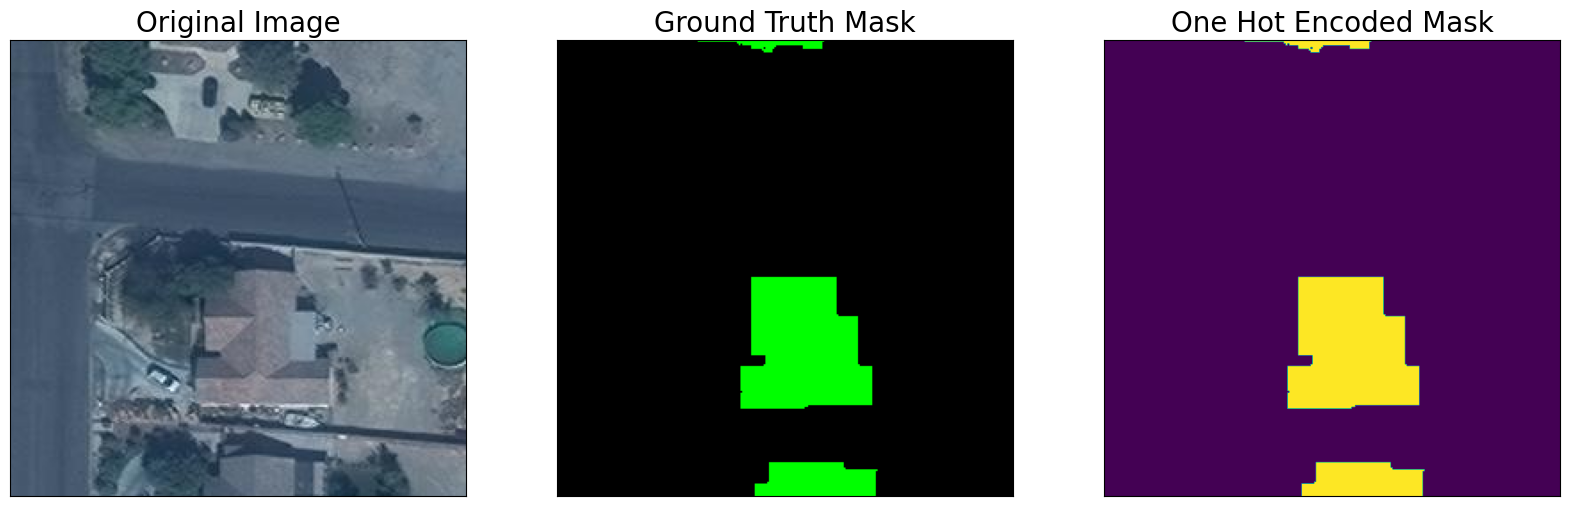

In [24]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides.
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [ ]:
# # Center crop padded image / mask to original image dims
# def crop_image(image, target_image_dims=[256,256,3]):#target_image_dims=[1500,1500,3]):

#     target_size = target_image_dims[0]
#     image_size = len(image)
#     padding = (image_size - target_size) // 2

#     return image[
#         padding:image_size - padding,
#         padding:image_size - padding,
#         #:,
#     ]

In [25]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
# for idx in range(len(old_test_dataset)):

#     random_idx = random.randint(0, len(old_test_dataset)-1)
#     image, gt_mask = old_test_dataset[random_idx]
#     image_vis = crop_image(old_test_dataset_vis[random_idx][0].astype('uint8'))
#     x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     # Predict test image
#     pred_mask = old_best_model(x_tensor)
#     pred_mask = pred_mask.detach().squeeze().cpu().numpy()
#     # Convert pred_mask from `CHW` format to `HWC` format
#     pred_mask = np.transpose(pred_mask,(1,2,0))
#     # Get prediction channel corresponding to building
#     pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
#     pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
#     # Convert gt_mask from `CHW` format to `HWC` format
#     gt_mask = np.transpose(gt_mask,(1,2,0))
#     gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
#     cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

#     visualize(
#         original_image = image_vis,
#         ground_truth_mask = gt_mask,
#         predicted_mask = pred_mask,
#         predicted_building_heatmap = pred_building_heatmap
#     )

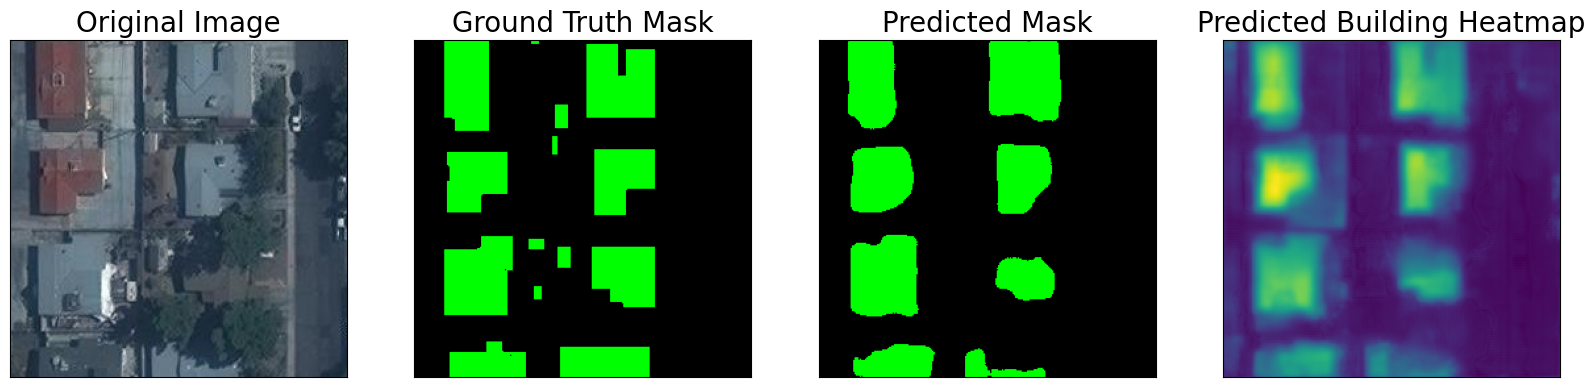

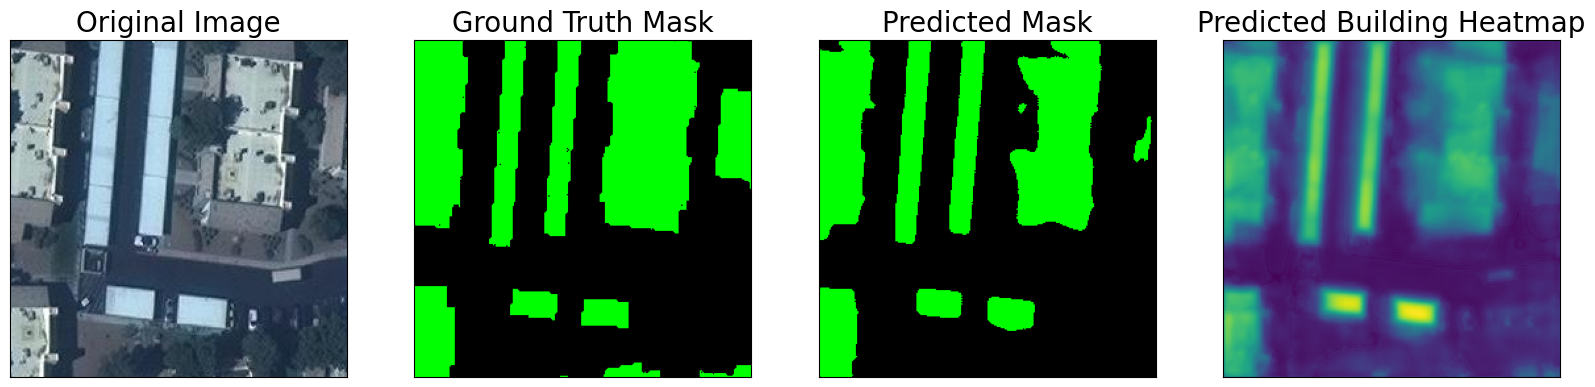

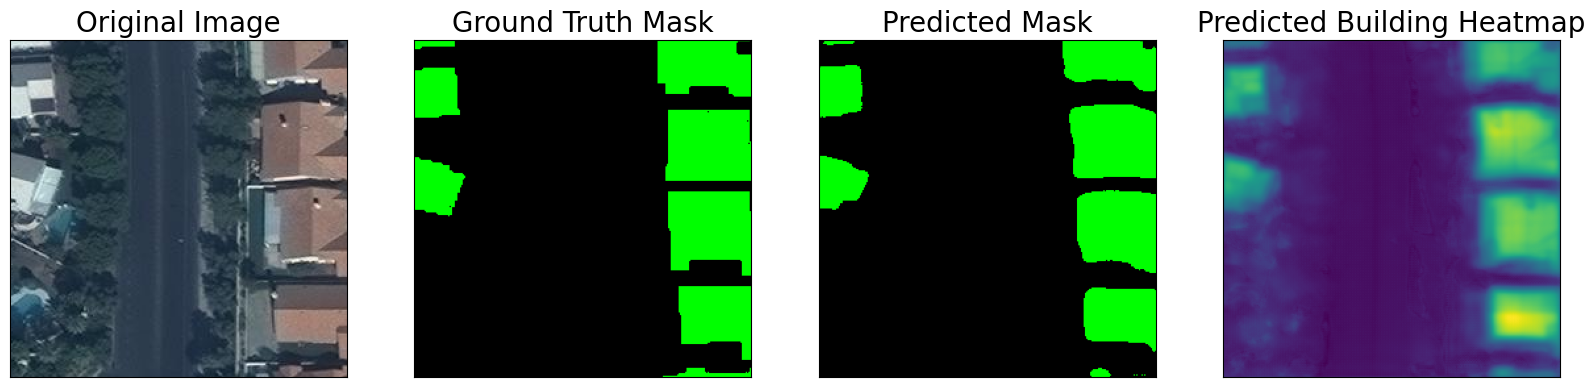

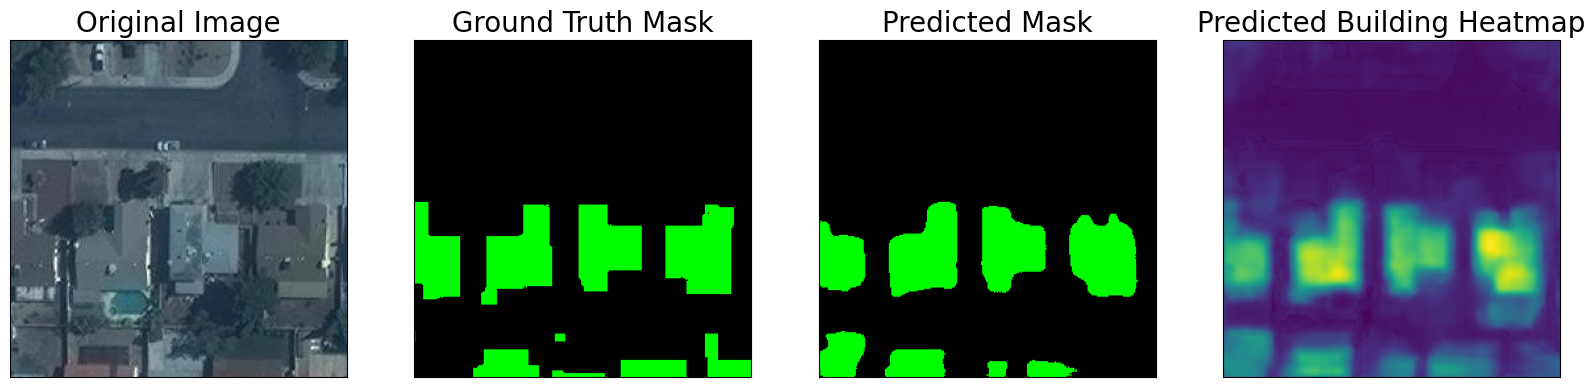

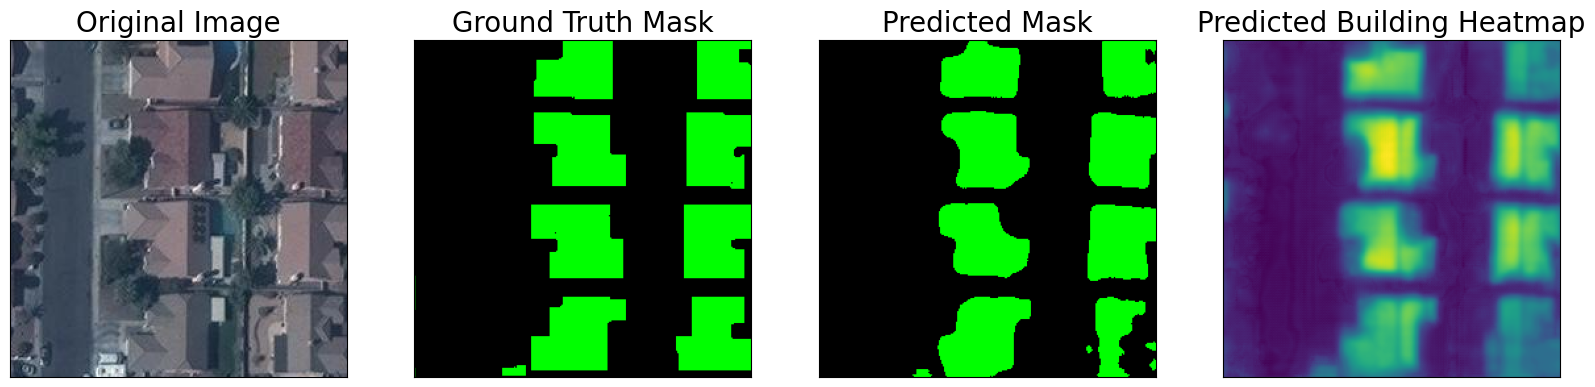

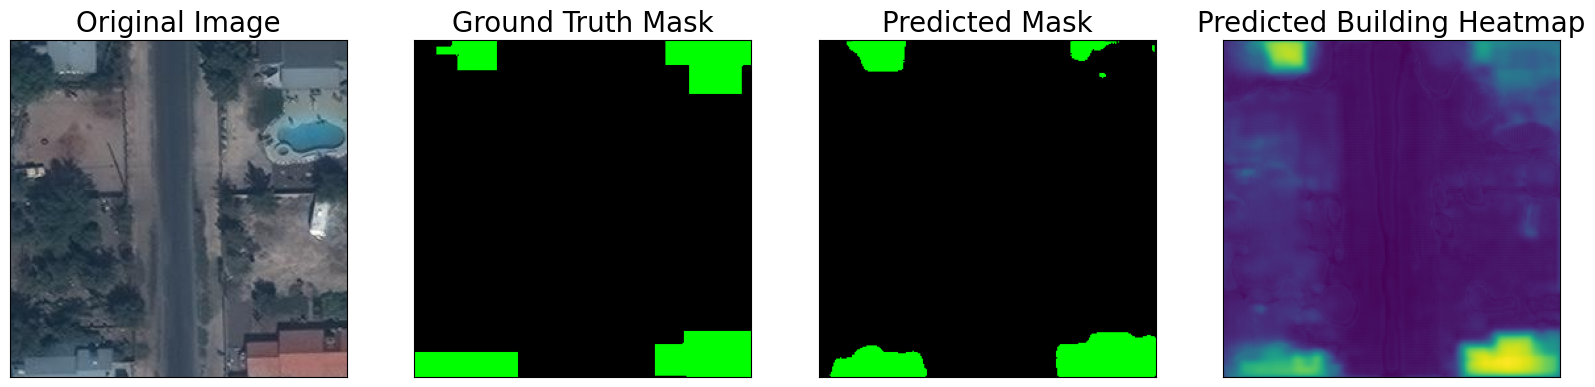

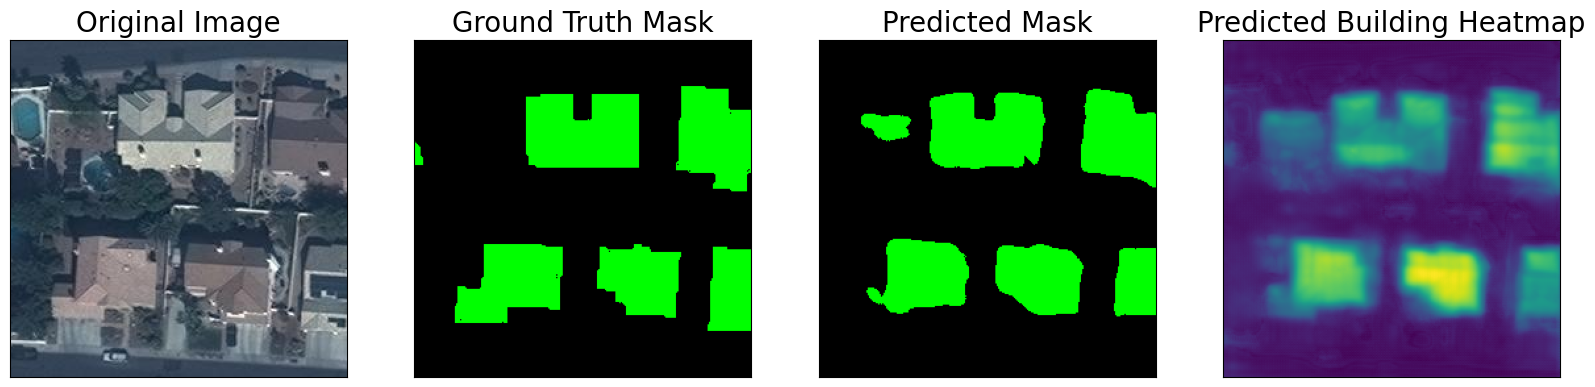

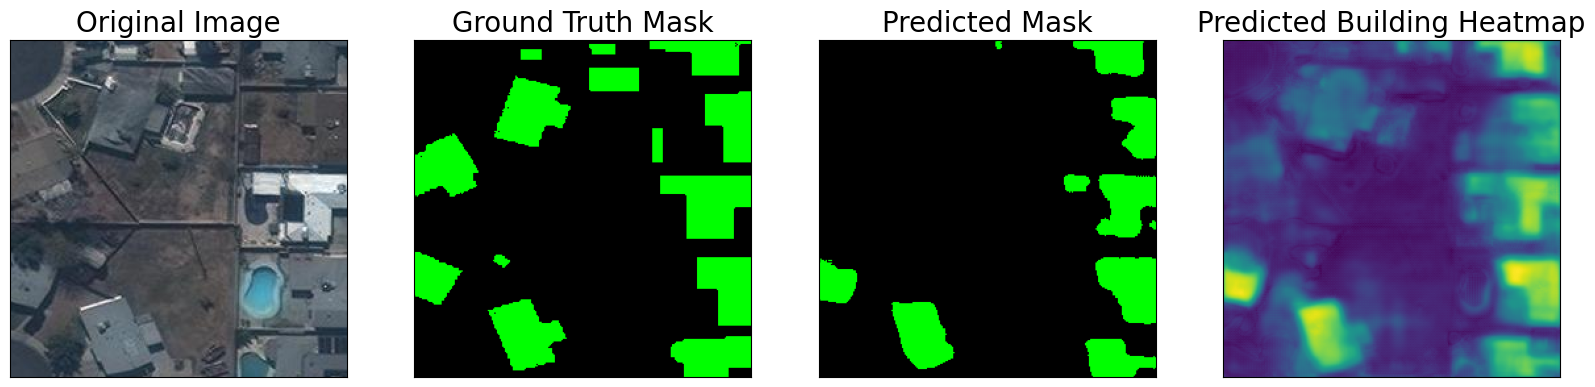

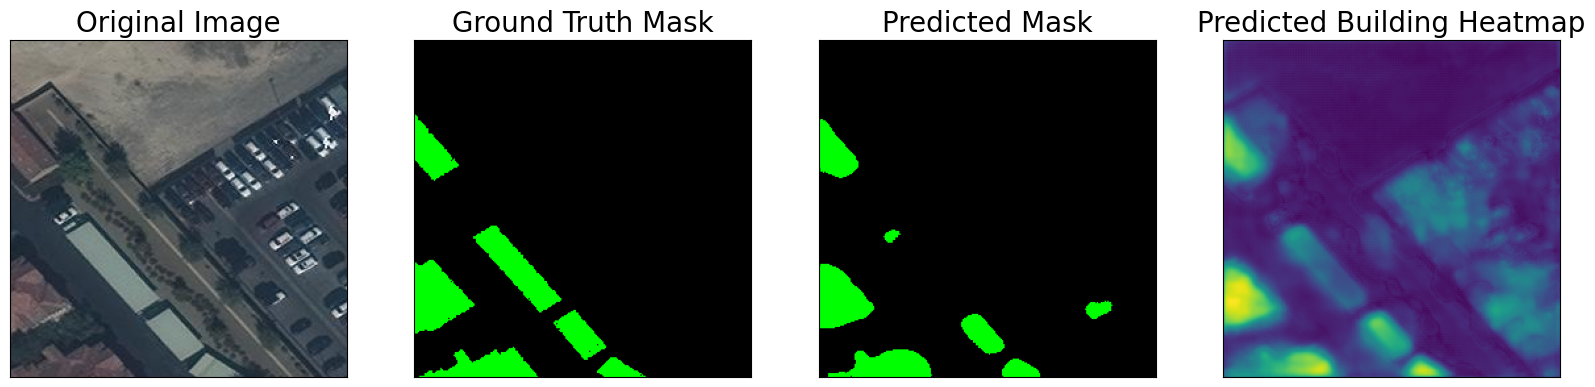

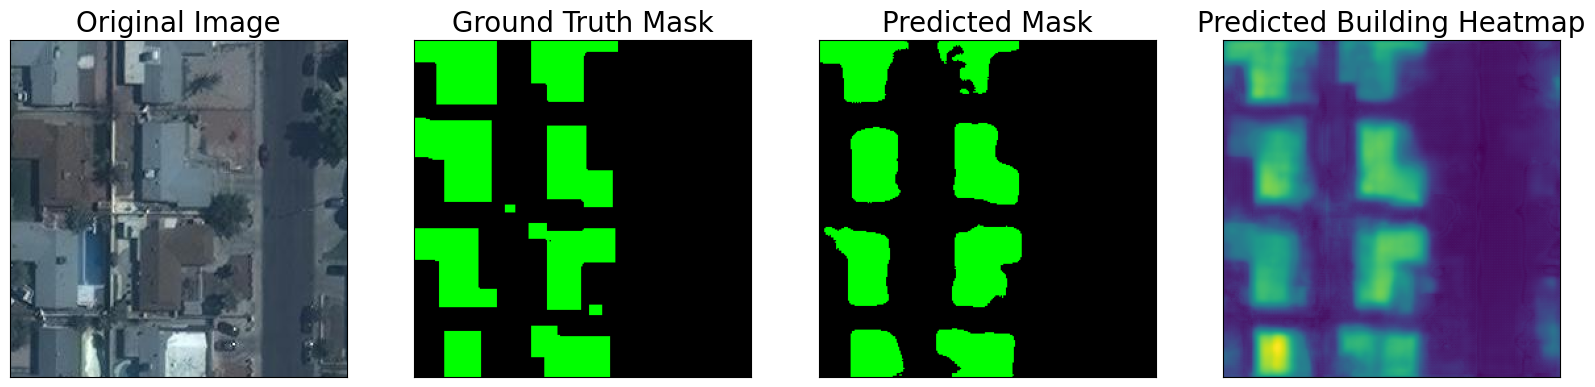

In [26]:
for idx in range(10):

    random_idx = random.randint(0, len(test_dataset)-1)
    image, gt_mask = test_dataset[random_idx]
    image_vis = test_dataset_vis[random_idx][0].astype('uint8') #crop_image(test_dataset_vis[random_idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values) #crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values) #crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

### Model Evaluation on Test Dataset

In [29]:
valid_logs.keys()

dict_keys(['CrossEntropyLoss', 'iou_score'])

In [30]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['CrossEntropyLoss']:.4f}")

valid: 100%|██████████| 156/156 [00:05<00:00, 26.50it/s, CrossEntropyLoss - 0.7678, iou_score - 0.08535]
Evaluation on Test Data: 
Mean IoU Score: 0.0853
Mean Dice Loss: 0.7678


### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
# old_train_logs_df = pd.DataFrame(old_train_logs_list)
# old_valid_logs_df = pd.DataFrame(old_valid_logs_list)
# old_train_logs_df.T

In [31]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

NameError: ignored

In [ ]:
# plt.figure(figsize=(20,8))
# plt.plot(old_train_logs_df.index.tolist(), old_train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
# plt.plot(old_valid_logs_df.index.tolist(), old_valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
# plt.xlabel('Epochs', fontsize=21)
# plt.ylabel('IoU Score', fontsize=21)
# plt.title('Old IoU Score Plot', fontsize=21)
# plt.legend(loc='best', fontsize=16)
# plt.grid()
# plt.savefig('iou_score_plot.png')
# plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [ ]:
# plt.figure(figsize=(20,8))
# plt.plot(old_train_logs_df.index.tolist(), old_train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
# plt.plot(old_valid_logs_df.index.tolist(), old_valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
# plt.xlabel('Epochs', fontsize=21)
# plt.ylabel('Dice Loss', fontsize=21)
# plt.title('Old Dice Loss Plot', fontsize=21)
# plt.legend(loc='best', fontsize=16)
# plt.grid()
# plt.savefig('dice_loss_plot.png')
# plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()